In [134]:
import os
import time
import numpy as np
import scipy as sp
import pandas as pd
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io
import scipy.sparse
import itertools

# Customize plot colors for dark backgrounds
%matplotlib inline
mpl.rcParams['axes.edgecolor'] = 'grey'
mpl.rcParams['grid.color'] = '#66CCCC'
mpl.rcParams['text.color'] = '#0EBFE9'
mpl.rcParams['xtick.color'] = '#66CCCC'
mpl.rcParams['ytick.color'] = '#66CCCC'
mpl.rcParams['axes.labelcolor'] = '#0EBFE9'

import IPython.utils.path
DATA_DIR = os.path.join(IPython.utils.path.get_home_dir(), 'work/recog/resources/')
print 'Data directory:', DATA_DIR
dataset_name = 'recom'

Data directory: /Users/kikohs/work/recog/resources/


In [143]:
data = sp.io.loadmat(os.path.join(DATA_DIR, 'recom_data.mat'))

### Description

- A_gt = A ground truth
- B_gt = B ground truth
- C = ground truth
- A init = Initialisation A because the problem is non convex
- B init = Initialisation B
- KA, KB = graph gradient operators for A, B
- O = Omega = observation mask
- WB = graph of B (songs)
- perc: percentage of observation
- norm A: norm of operator A


In [198]:
def plot_factor_mat(img):
    h = plt.imshow(img, interpolation='nearest', aspect='auto')
    h.axes.set_position([0, 0, 1, 1])
    h.axes.set_xlim(-1, img.shape[1])
    h.axes.set_ylim(img.shape[0], -1)


def soft_thresholding(data, value, substitute=0):
    mvalue = -value
    cond_less = np.less(data, value)
    cond_greater = np.greater(data, mvalue)
    data = np.where(cond_less & cond_greater, substitute, data)
    data = np.where(cond_less, data + value, data)
    data = np.where(cond_greater, data - value, data)
    return data


def init(nb_row, nb_col, rank):
    a = np.random.random((nb_row, rank))
    b = np.random.random((rank, nb_col))
    a /= np.linalg.norm(a, axis=0) 
    b = (b.T / np.linalg.norm(b, axis=1)).T
    return a, b


def graph_gradient_operator(g, key='weight'):
    k = sp.sparse.dok_matrix((g.number_of_edges(), g.number_of_nodes()))
    for i, (src, tgt, data) in itertools.izip(itertools.count(), g.edges_iter(data=True)):
        k[i, src] = data[key]
        k[i, tgt] = -data[key]
    return sp.sparse.csr_matrix(k)


def update_step(nb_iter, theta_tv, A, B, ka, norm_ka, kb, norm_kb, omega, oc):
    B, A = update_factor(theta_tv, B, A, kb, norm_kb, omega, oc)
    A, B = update_factor(theta_tv, A.T, B.T, ka, norm_ka, omega.T, oc.T)
    A, B = A.T, B.T
    return A, B


def update_factor(theta_tv, X, Y, K, normK, omega, OC):
    # L2-norm of columns
    X = (X.T / np.linalg.norm(X, axis=1)).T
    Y = Y / np.linalg.norm(Y, axis=0)

    # Primal variable
    Xb = X  
    Xold = X
    # First dual variable
    P1 = Y.dot(X)
    # Second dual variable
    P2 = K.dot(X.T)

    # 2-norm largest sigular value
    normY = np.linalg.norm(Y, 2)
    
    # Primal-dual parameters
    gamma1 = 1e-1;
    gamma2 = 1e-1;

    # init timestamps
    sigma1 = 1.0 / normY;
    tau1 = 1.0 / normY;
    sigma2 = 1.0 / normK;
    tau2 = 1.0 / normK;


    # TODO: create better loop
    inner_loop = 1000
    for j in xrange(inner_loop):

        # update P1 (NMF part)
        P1 += sigma1 * Y.dot(Xb)
        t = (P1 - omega)**2 + 4 * sigma1 * OC
        P1 = 0.5 * (P1 + omega - np.sqrt(t))

        # update P2 (TV)
        P2 += sigma2 * K.dot(Xb.T)
        P2 -= sigma2 * soft_thresholding(P2 / sigma2, theta_tv / sigma2)

        # new primal variable
        X = X - tau1 * (Y.T.dot(P1)) - tau2 * (K.T.dot(P2)).T
        # set negative values to 0 (element wise)
        X = np.maximum(X, 0)

        # Acceleration, update timesteps
        theta1 = 1. / np.sqrt(1 + 2 * gamma1 * tau1)
        tau1 = tau1 * theta1
        sigma1 = sigma1 / theta1
        theta2 = 1./ np.sqrt( 1 + 2 * gamma2 * tau2)
        tau2 = tau2 * theta2
        sigma2 = sigma2 / theta2

        # update primal variable for acceleration
        t = X - Xold
        Xb = X + 0.5 * theta1 * t + 0.5 * theta2 * t

        # update Xold
        Xold = X

    return X, Y


def convert_adjacency_matrix(W):
    G = W
    if isinstance(W, sp.sparse.base.spmatrix):
        G = nx.from_scipy_sparse_matrix(W)
    assert(isinstance(G, nx.Graph))
    # Remove self-edges
    G.remove_edges_from(G.selfloop_edges())
    return G


def proximal_training(C, WA, WB, O, rank, theta_tv=1e-4*5, nb_iter_max=20):
    GA = convert_adjacency_matrix(WA)
    GB = convert_adjacency_matrix(WB)
    
    A, B = init(C.shape[0], C.shape[1], rank)
    
    KA = graph_gradient_operator(GA)
    KB = graph_gradient_operator(GB)
     
    # For sparse matrix
    _, normKA, _ = sp.sparse.linalg.svds(KA, 1)
    _, normKB, _ = sp.sparse.linalg.svds(KB, 1)
    
    # Mask over rating matrix, computed once
    OC = O * C
    
    # TODO better iter
    nb_iter_max = 20
    for i in range(nb_iter_max):
        A, B = update_step(i, theta_tv, A, B, KA, normKA, KB, normKB, O, OC)
        print 'Err: ', np.linalg.norm(C - A.dot(B))
        
    return A, B

In [199]:
A, B = proximal_training(data['C'], data['WA'], data['WB'], data['O'], data['Agt'].shape[1])

# plot_factor_mat(B)

Err:  0.938239303441
Err:  0.394597889159
Err:  0.299874431683
Err:  0.266610175918
Err:  0.251698290111
Err:  0.245551327827
Err:  0.243011877841
Err:  0.240847411877
Err:  0.239760310137
Err:  0.239119652834
Err:  0.238218402224
Err:  0.23760812044
Err:  0.236878046316
Err:  0.23638218565
Err:  0.236028296772
Err:  0.235851009218
Err:  0.235780746726
Err:  0.235935467208
Err:  0.23611963479
Err:  0.236319691056


### Plot results

In [171]:
# plot_factor_mat(data['B'])

In [172]:
# plot_factor_mat(data['Bgt'])

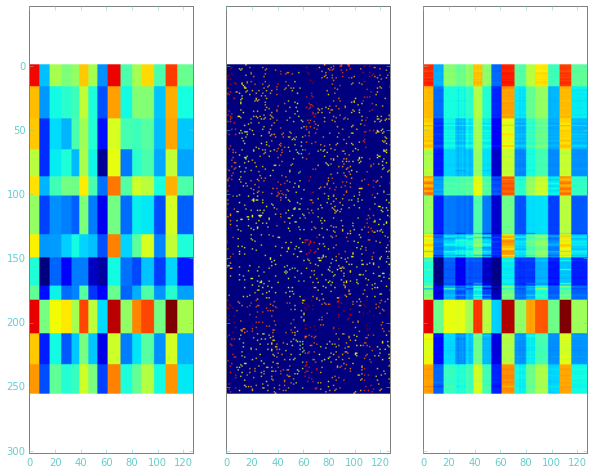

In [112]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True)
fig.set_size_inches((10, 8))
ax1.imshow(data['C'])
ax2.imshow(data['C'] * data['O'])
ax3.imshow(A.dot(B))

### Recommender part

In [173]:
results = sp.io.loadmat(os.path.join(DATA_DIR, 'result_AB.mat'))

In [195]:
def keypoint_test(C, obs=0.05, row=15):
    # TODO
#     if not given rand
    c_test = C[row, :]
    to_pick = int(len(c_test) * obs)
    mask = np.random.choice(range(len(c_test)), to_pick)    
    return zip(mask, c_test[mask])
                                     
    
def recommend(A, B, keypoints):
    """Keypoints: list of tuple (movie, rating)"""
    
    rank = B.shape[0]
    length = B.shape[1]
    
    mask = np.zeros(length)
    mask_idx = map(lambda x: x[0], keypoints)
    mask[mask_idx] = 1.0
    mask = np.diag(mask)
    
    ratings = np.zeros(length)
    ratings[mask_idx] = map(lambda x: x[1], keypoints)

    z = B.dot(mask).dot(B.T) + 1e-3 * np.eye(rank)
    q = B.dot(mask).dot(ratings)

    # Results
    x = np.linalg.solve(z, q)
    return x.T.dot(B)
        
    
row = 15
c_test = keypoint_test(data['C'], row=row)
c_reco = recommend(A, B, c_test)

np.linalg.norm(data['C'][row, :] - c_reco)

0.017886238869757706

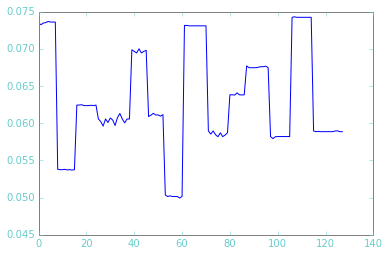

In [196]:
plt.plot(c_reco)

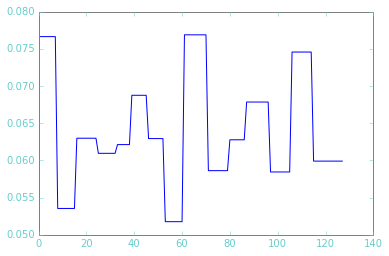

In [197]:
plt.plot(data['C'][row, :])